Entering comparison code
50 most similar pairs of speeches by different presidents
0.724299870882: William J. Clinton 1995 Barack Obama 2010
0.71948479195: William J. Clinton 1995 Barack Obama 2011
0.710569236827: William J. Clinton 1995 Barack Obama 2013
0.709412531729: William J. Clinton 1995 Barack Obama 2012
0.689458310524: George Bush 1992 William J. Clinton 1995
0.67022282756: William J. Clinton 1994 Barack Obama 2010
0.663996085883: George Bush 1992 William J. Clinton 1994
0.662321665159: William J. Clinton 1994 Barack Obama 2011
0.66162674439: William J. Clinton 1994 Barack Obama 2013
0.658209724277: George Bush 1992 Barack Obama 2011
0.65603011247: William J. Clinton 1994 Barack Obama 2012
0.651400633829: William J. Clinton 1993 Barack Obama 2011
0.649608139049: William J. Clinton 1995 Barack Obama 2009
0.648968376217: William J. Clinton 1998 Barack Obama 2011
0.64780599563: George Bush 1992 Barack Obama 2010
0.63984576068: William J. Clinton 1994 Barack Obama 2009
0.635137836

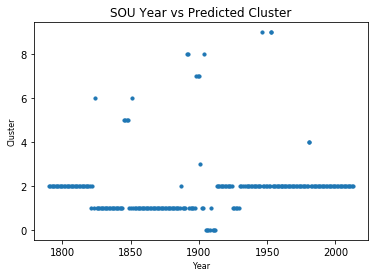

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pylab
import numpy as np
import os
import re
import math
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext

ORDERED_VOCAB_LIST = [] # READ_ONLY after initialization, to get a constant order on the weights vector
MASTER_VOCAB_DICT = {} # READ_ONLY after initialization, maps word -> (num occurences, set(years))
MASTER_DOC_TERMCOUNT_DICT = {} # READ_ONLY after initialization. # maps doc. year -> word -> occurence count

MASTER_WEIGHTS_VECTORS_DICT = {} # READ_ONLY after initialization, maps doc. id -> ([vector], magnitude (of vector))

MASTER_COMPARISON_SCORES_DICT = {} # READ_ONLY after initialization, maps doc. id 1 -> {doc. id 2 -> comparison of 1 and 2} 

NOT_IN_VOCAB_KEY = "NOT_IN_VOCAB"

#### Data generation functions ####

def wordCountFlatMap(row):
    # replace non-alphanumeric with ' ', then split on runs of whitespace
    originating_doc = str(row['year']).strip()
    word_list = re.sub(r"\W+", ' ', row['text']).lower().split()
    
    for i in range(len(word_list)):
        word_list[i] = word_list[i] + originating_doc # encode document year in string 
    return word_list

def wordCountMap(word):
    originating_doc = word[-4:] # retrieve document year
    doc_set = set()
    doc_set.add(originating_doc)
    return (word[:-4], (1, doc_set))

def wordCountReduce(x, y): # to be called with reduce by key
    return (x[0] + y[0], x[1] | y[1]);

def initVocab(wordcount_list): # Should be called only ONCE
    wordcount_list.sort(key = lambda x: x[1][0], reverse=True) # sort by wordcount
    try:
        common_cutoff = 20 - 1 # cutoff most common 20 words
        uncommon_cutoff = 50 # cutoff all words with less than 50 appearances
        for i in range(common_cutoff, len(wordcount_list)):
            if wordcount_list[i][1][0] < uncommon_cutoff: # the list is sorted, so this means we have hit our cutoff
                break
            else:
                MASTER_VOCAB_DICT[wordcount_list[i][0]] = wordcount_list[i][1] # maps word -> (num occurences, set(years))
                ORDERED_VOCAB_LIST.append(wordcount_list[i][0])
        return
                
    except IndexError:
        print "[ERROR]: Data malformed or cutoff bound incorrect."
        
def docOccurenceMap(word): # operates on output from wordCountFlatMap
    originating_doc = word[-4:] # retrieve document year
    occ_dict = {}
    occ_dict[word[:-4]] = 1
    return (originating_doc, occ_dict)

# to be called with reduceByKey, creates dict of form word -> count for a given doc.
# DOES NOT filter on vocabulary
# Fairly efficient, new keys are written only when needed, old values are summed
def docOccurenceReduce(x, y):
    if len(x) > len(y): # we do not want to copy values into the smaller dict from the larger
        for key in y:
            if key in x:
                x[key] += y[key]
            else:
                x[key] = 1
        return x
    else:
        for key in x:
            if key in y:
                y[key] += x[key]
            else:
                y[key] = 1
        return y
    
def initDocTermCounts(doc_wordcount_list):
    for key, wordcount_dict in doc_wordcount_list:
        # this is another dictionary of the form word -> count
        MASTER_DOC_TERMCOUNT_DICT[key] = wordcount_dict
        
    return

def doVectorWeightsMap(word): # operates on output from wordCountFlatMap, returns (doc. year, word -> weight (float)))
    originating_doc = word[-4:] # retrieve document year
    decoded_word = word[:-4]
    return_dict = {}
    if decoded_word in MASTER_VOCAB_DICT: # is the word in the vocabulary
        numOccurencesInDoc = 0
        if decoded_word in MASTER_DOC_TERMCOUNT_DICT[originating_doc]: # is word in document
            numOccurencesInDoc = MASTER_DOC_TERMCOUNT_DICT[originating_doc][decoded_word]
        else: # save ourselves some computation, return 0
            return_dict[decoded_word] = 0.0
            return (originating_doc, return_dict) 
        
        collectionDocTotal = len(MASTER_DOC_TERMCOUNT_DICT)
        numDocsContainingWord = len(MASTER_VOCAB_DICT[decoded_word][1]) # length of the set of all documents which have a term t
        
        weight = 0.0
        if numDocsContainingWord > 0: # safety check, should never fail
            weight = numOccurencesInDoc * math.log(float(collectionDocTotal) / float(numDocsContainingWord))
        else:
            print "ERROR: no documents contain word weight is being calculated for"
        
        return_dict[decoded_word] = weight    
        return (originating_doc, return_dict)
        
    else:
        return_dict[decoded_word] = -1.0
        return (NOT_IN_VOCAB_KEY, return_dict)
    
def doVectorWeightsReduce(x, y): # to be called with reduceByKey
    if len(x) > len(y): # shorter dictionary is used to minimize iterations
        for key in y:
            if key not in x:
                x[key] = y[key]

        return x
    else:
        for key in x:
            if key not in y:
                y[key] = x[key]

        return y

def initWeightVectors(unordered_weights_list):
    for doc_id, weights_dict in unordered_weights_list:
        if doc_id != NOT_IN_VOCAB_KEY:
            vector = []
            for word in ORDERED_VOCAB_LIST:
                try: # order the vectors in some consistent but arbitrary ordering of the vocabulary
                    vector.append(weights_dict[word])
                except KeyError: # attempted to look a word which is in the vocabulary, but not this document
                    vector.append(0.0)

            magnitude = np.linalg.norm(vector)
            MASTER_WEIGHTS_VECTORS_DICT[doc_id] = (vector, magnitude)

    return

#### Data Comparision/Visualization Functions ####

def calculateComparisonsMap(row): # returns a k,v pair of (doc. id 1 -> {doc. id != 1 -> score})
    comparison_dict = {}
    outer_sou_key = row['year'] # only reason we are mapping using the original rdd

    # TODO: create ordered keylist of MASTER_WEIGHTS_VECTORS_DICT? Returning dict so not nessecary?
    for inner_sou_key in MASTER_WEIGHTS_VECTORS_DICT:
        if outer_sou_key != inner_sou_key:
            numerator = np.dot(MASTER_WEIGHTS_VECTORS_DICT[outer_sou_key][0],
                               MASTER_WEIGHTS_VECTORS_DICT[inner_sou_key][0])
            # precomputed magnitudes
            denominator = MASTER_WEIGHTS_VECTORS_DICT[outer_sou_key][1] * \
                          MASTER_WEIGHTS_VECTORS_DICT[inner_sou_key][1]

            comparison_dict[inner_sou_key] = float(numerator) / float(denominator)
                                   
    return (outer_sou_key, comparison_dict)


    
######################################################################################################################

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')
word_rdd = df.rdd.flatMap(wordCountFlatMap)
wordcount_list = word_rdd.map(wordCountMap).reduceByKey(wordCountReduce).collect()
initVocab(wordcount_list) # MASTER_VOCAB_DICT is read_only at this point
doc_wordcount_list = word_rdd.map(docOccurenceMap).reduceByKey(docOccurenceReduce).collect() # term counts per doc
initDocTermCounts(doc_wordcount_list)

unordered_weights_list = word_rdd.map(doVectorWeightsMap).reduceByKey(doVectorWeightsReduce).collect()

initWeightVectors(unordered_weights_list)

########### Comparison code ############
print "Entering comparison code"

# make sure the order of keys is consistent for the double loop. Must be ordered on years
years_list = []
# make sure the order of keys is consistent for the double loop. Must be ordered on year for code to work
pres_list = []

presidential_mapping_dict = {}
for row in df.rdd.collect(): # initialize some helpful data structs
    years_list.append(row['year'])  
    presidential_mapping_dict[row['year']] = row['president']

years_list.sort()
for year in years_list:
    president = presidential_mapping_dict[year]
    if len(pres_list) == 0:
        pres_list.append(president)
    else:
        if pres_list[-1] != president:
            pres_list.append(president)

# print MASTER_WEIGHTS_VECTORS_DICT

comparisons_list = df.rdd.map(calculateComparisonsMap).collect()
for outer_sou_key, comparison_dict in comparisons_list:
    MASTER_COMPARISON_SCORES_DICT[outer_sou_key] = comparison_dict
        
    
# compare
diff_president_sou = []
same_president_sou = []

averaged_similarity_dict = {}
# NOTE: using indexes so we do not get duplicates in the intermediate results (i.e compare 1900 with 2000, 2000 with 1900)
for i in range(len(years_list)):
    for j in range(i + 1, len(years_list)):
        outer_year = years_list[i]
        inner_year = years_list[j]
        if (outer_year != inner_year):
            outer_president = presidential_mapping_dict[outer_year]
            inner_president = presidential_mapping_dict[inner_year]
            if (outer_president == inner_president): # are presidents the same
                same_president_sou.append((MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year],
                                          (outer_president, outer_year, inner_president, inner_year))) # get comparison scores
            else:
                diff_president_sou.append((MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year],
                                          (outer_president, outer_year, inner_president, inner_year))) # get comparison scores
                                          
                # handle averaging scores between presidents
                if outer_president not in averaged_similarity_dict:
                    averaged_similarity_dict[outer_president] = {}
                if inner_president not in averaged_similarity_dict[outer_president]:
                    averaged_similarity_dict[outer_president][inner_president] = [0.0, 0]
                averaged_similarity_dict[outer_president][inner_president][0] += \
                                          MASTER_COMPARISON_SCORES_DICT[outer_year][inner_year] # update score count
                averaged_similarity_dict[outer_president][inner_president][1] += 1 # update count
                                          

diff_president_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first
same_president_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first

avg_presidents_sou = []
for i in range(len(pres_list)):
    for j in range(i + 1, len(pres_list)):
        if (pres_list[i] != pres_list[j]): # handles Grover Cleveland and his non-consecutive terms
            numerator = averaged_similarity_dict[pres_list[i]][pres_list[j]][0]
            denominator = averaged_similarity_dict[pres_list[i]][pres_list[j]][1]
            avg_presidents_sou.append((float(numerator) / float(denominator), pres_list[i], pres_list[j]))
            
avg_presidents_sou.sort(key = lambda x: x[0], reverse=True) # sort by score, highest first

### RESULTS ###
print "50 most similar pairs of speeches by different presidents"
for score, names_tuple in diff_president_sou[:50]:
    print str(score) + ": " + " ".join(str(x) for x in names_tuple)
print
print "50 most similar pairs of speeches by the same presidents"
for score, names_tuple in same_president_sou[:50]:
    print str(score) + ": " + " ".join(str(x) for x in names_tuple)
print
print "25 most similar pairs of presidents on average"
for data_tuple in avg_presidents_sou[:25]:
    print str(data_tuple[0]) + ": " + data_tuple[1] + " " + data_tuple[2]
print

            
print "Exiting comparison code"
# CHECK: Make sure that the below statement is correct
print "It appears that the SOUs tend to rate speeches which are temporally close by as more similar, reflecting what are likely \
similarities in the language and the issues being addressed at those times. \
For better similarity, it may be nessecary to not only consider the frequency of words, but also their relative spacing \
to other words. For example, the fact that a speech mentions America is important, but so is the grammatrical context in which \
it is mentioned in. Grammatical rules, however, are sophisticated, and as such, this is a difficult problem."
############################################################

print "Entering visualization /clustering code"

pre_rdd_list = []
for doc_id in years_list:
    # label = doc_id
    data = MASTER_WEIGHTS_VECTORS_DICT[doc_id][0] # pull out tf-idf weights
    # pre_rdd_list.append(LabeledPoint(label, data))
    pre_rdd_list.append(data)
    

train_data = spark.sparkContext.parallelize(pre_rdd_list, len(pre_rdd_list))

clusters = KMeans.train(train_data, 10, maxIterations=50, runs=10, initializationMode="random")
 
cluster_list = clusters.predict(train_data).collect() # assigned clusters for speech, ordered by speech year 

plt.clf()
plt.figure(1)
 
plt.scatter(years_list, cluster_list, s = 10)
plt.title('SOU Year vs Predicted Cluster', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Cluster', fontsize = 8)
 
plt.show()

spark.stop()